# Lab Sprint: Multiscale organization of social brain networks

# Behavioral Decoding

2-4 August 2022

Script author: Bianca Serio

## Load packages

In [217]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv

# Computing
#import scipy.io  # loadmat
#from scipy import stats
#import sklearn 
#from brainstat.stats.terms import FixedEffect
#from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
#import seaborn as sns
#import vtk
#from IPython.display import display
#import matplotlib.collections as clt
#import ptitprince as pt

# Neuroimaging
import nibabel
from nibabel import gifti
from nibabel.freesurfer.io import read_annot
import nilearn
from nilearn.surface import load_surf_data


# Gradients
#import brainspace
#from brainspace.datasets import load_parcellation, load_conte69
#from brainspace.plotting import plot_hemispheres
#from brainspace.gradient import GradientMaps
#from brainspace.utils.parcellation import map_to_labels

## Define directories

In [218]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/pt_02542/social_networks/data/'

resdir = '/data/pt_02542/social_networks/results/Decoding/bianca/'

#os.makedirs(resdir, exist_ok=True)

# Behavioral Decoding

## Neurosynth via Brainstat

https://neurosynth.org/analyses/topics/
https://github.com/neurosynth/neurosynth-data

Tweaking Neurosynth's meta_analytic_decoder:
- adding column with p-vals
- adding column with abs corrcoef
- changing to descending for abs corrcoef

In [142]:
""" Meta-analytic decoding based on NiMARE """
import re
import urllib
import zipfile
from pathlib import Path
from tempfile import NamedTemporaryFile
from typing import Generator, Optional, Sequence, Union

import nibabel as nib
import numpy as np
import pandas as pd
import templateflow.api as tflow
from brainspace.vtk_interface.wrappers.data_object import BSPolyData
from scipy.stats.stats import pearsonr

from brainstat._utils import (
    data_directories,
    deprecated,
    logger,
    read_data_fetcher_json,
)
from brainstat.mesh.interpolate import _surf2vol, multi_surface_to_volume


from brainstat.context.meta_analysis import _fetch_precomputed




def meta_analytic_decoder_bianca(
    template: str,
    stat_labels: np.ndarray,
    data_dir: Optional[Union[str, Path]] = None,
):
    """Meta-analytic decoding of surface maps using NeuroSynth or NeuroQuery.
    
    Adjusted from
    ----------
    https://brainstat.readthedocs.io/en/master/_modules/brainstat/context/meta_analysis.html#meta_analytic_decoder
    original available through: from brainstat.context.meta_analysis import meta_analytic_decoder
    
    changes output dataframe:
        - adding column with abs corrcoef
        - adding column with p-vals
        - changing to descending for abs corrcoef

    Parameters
    ----------
    template : str
        Path of a template volume file.
    stat_labels : str, numpy.ndarray, sequence of str or numpy.ndarray
        Path to a label file for the surfaces, numpy array containing the
        labels, or a list containing multiple of the aforementioned.
    data_dir : str, optional
        The directory of the dataset. If none exists, a new dataset will
        be downloaded and saved to this path. If None, the directory defaults to
        your home directory, by default None.


    Returns
    -------
    pandas.DataFrame
        Table with correlation values for each feature.
    """
    data_dir = Path(data_dir) if data_dir else data_directories["NEUROSYNTH_DATA_DIR"]
    data_dir.mkdir(exist_ok=True, parents=True)

    logger.info(
        "Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet."
    )
    feature_files = tuple(_fetch_precomputed(data_dir, database="neurosynth"))

    mni152 = nib.load(tflow.get("MNI152Lin", resolution=2, desc="brain", suffix="mask"))

    stat_nii = _surf2vol(template, stat_labels.flatten())
    mask = (stat_nii.get_fdata() != 0) & (mni152.get_fdata() != 0)
    stat_vector = stat_nii.get_fdata()[mask]

    feature_names = []
    #correlations = np.zeros(len(feature_files))
    
    r_coef = np.zeros(len(feature_files))
    r_coef_abs = np.zeros(len(feature_files))
    pval = np.zeros(len(feature_files))

    logger.info("Running correlations with all Neurosynth features.")
    for i in range(len(feature_files)):
        feature_names.append(re.search("__[A-Za-z0-9 ]+", feature_files[i].stem)[0][2:])  # type: ignore
        feature_data = nib.load(feature_files[i]).get_fdata()[mask]
        keep = np.logical_not(
            np.isnan(feature_data)
            | np.isinf(feature_data)
            | np.isnan(stat_vector)
            | np.isinf(stat_vector)
        )
        #correlations[i], _ = pearsonr(stat_vector[keep], feature_data[keep])
        
        r_coef[i], r_coef_abs[i], pval[i], = pearsonr(stat_vector[keep], feature_data[keep])[0], abs(pearsonr(stat_vector[keep], feature_data[keep])[0]), pearsonr(stat_vector[keep], feature_data[keep])[1]
    
    correlations = {"Pearson's r": r_coef, "Pearson's r (abs)": r_coef_abs, "p-value": pval}
    df = pd.DataFrame(correlations, index=feature_names)
    return df.sort_values(by="Pearson's r (abs)", ascending=False)

## FC

In [140]:
# load the within cluster G1 eigenvalues (both hemispheres separately, each len = 10242 -> fsaverage) - this is a thresholded map (outside cluster = 0)
fc_G1_within_lh = load_surf_data('/data/pt_02542/social_networks/results/FC/lh.withinFCG1.func.gii')
fc_G1_within_rh = load_surf_data('/data/pt_02542/social_networks/results/FC/rh.withinFCG1.func.gii')

# load the cluster to rest G1 eigenvalues (both hemispheres separately, each len = 10242 -> fsaverage) - this is a thresholded map (outside cluster = 0)
fc_G1_between_lh = load_surf_data('/data/pt_02542/social_networks/results/FC/lh.betweenFCG1.func.gii')
fc_G1_between_rh = load_surf_data('/data/pt_02542/social_networks/results/FC/rh.betweenFCG1.func.gii')

In [141]:
# combine hemispheres to have G1 eigenvalues projected on wholebrain fsaverage  (len 20484) - this is a thresholded map (outside cluster = 0)
fc_G1_within_wholebrain = np.concatenate((fc_G1_within_lh, fc_G1_within_rh), axis=0)
fc_G1_between_wholebrain = np.concatenate((fc_G1_between_lh, fc_G1_within_rh), axis=0)

### Within-cluster FC

In [149]:
# run meta analysis
meta_analysis_fc_G1_within = meta_analytic_decoder_bianca("fsaverage5", fc_G1_within_wholebrain) 

2022-08-04 10:15:35,587 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-08-04 10:15:35,759 - brainstat - INFO - Running correlations with all Neurosynth features.


In [150]:
meta_analysis_fc_G1_within

,Pearson's r,Pearson's r (abs),p-value
contralateral,0.726971,0.726971,0.000000
ipsilateral,0.719844,0.719844,0.000000
somatosensory,0.708970,0.708970,0.000000
stimulation,0.707650,0.707650,0.000000
stimulated,0.705060,0.705060,0.000000
...,...,...,...
memory performance,0.001696,0.001696,0.814369
manifest,0.001455,0.001455,0.840366
mental,0.001100,0.001100,0.878940
strategic,-0.000840,0.000840,0.907460


In [221]:
# export meta analysis results to csv
meta_analysis_fc_G1_within.to_csv(resdir+'decoding_results_fc_G1_within.csv')

### Between cluster and rest of brain FC

In [152]:
# run meta analysis
meta_analysis_fc_G1_between = meta_analytic_decoder_bianca("fsaverage5", fc_G1_between_wholebrain) 

2022-08-04 10:37:29,400 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-08-04 10:37:29,622 - brainstat - INFO - Running correlations with all Neurosynth features.


In [154]:
meta_analysis_fc_G1_between

,Pearson's r,Pearson's r (abs),p-value
contralateral,0.664259,0.664259,0.000000
ipsilateral,0.655950,0.655950,0.000000
stimulated,0.652767,0.652767,0.000000
stimulation,0.652740,0.652740,0.000000
primary,0.647441,0.647441,0.000000
...,...,...,...
risk,-0.001018,0.001018,0.887907
reappraisal,0.000934,0.000934,0.897125
mdd,-0.000480,0.000480,0.947041
daily life,-0.000411,0.000411,0.954653


In [222]:
# export meta analysis results to csv
meta_analysis_fc_G1_between.to_csv(resdir+'decoding_results_fc_G1_between.csv')

### Plotting

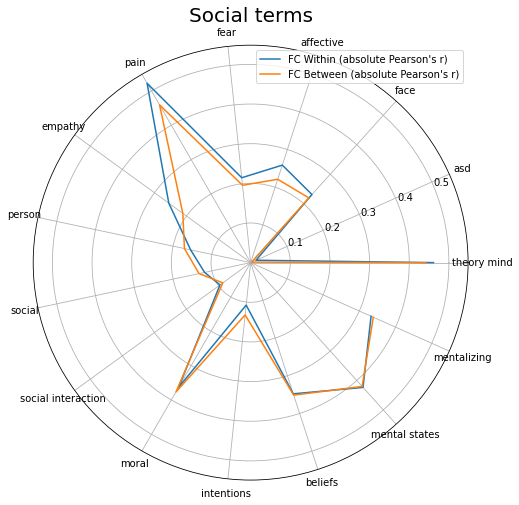

<Figure size 432x288 with 0 Axes>

In [216]:
social_categories = ['theory mind', 'asd', 'face', 'affective', 'fear', 'pain', 'empathy', 'person', 'social', 'social interaction', 'moral', 'intentions', 'beliefs', 'mental states', 'mentalizing']

within = [meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['theory mind'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['asd'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['face'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['affective'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['fear'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['pain'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['empathy'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['person'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['social'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['social interaction'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['moral'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['intentions'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['beliefs'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['mental states'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['mentalizing']
]

between = [meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['theory mind'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['asd'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['face'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['affective'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['fear'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['pain'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['empathy'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['person'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['social'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['social interaction'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['moral'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['intentions'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['beliefs'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['mental states'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['mentalizing']
]

#label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(social))
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(social_categories)+1)[0:len(social_categories)]

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, within, label="FC Within (absolute Pearson's r)")
plt.plot(label_loc, between, label="FC Between (absolute Pearson's r)")
plt.title('Social terms', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=social_categories)
plt.legend()
plt.show()

# export figure
plt.savefig(resdir+'social_decoding_FC_within_between.png')

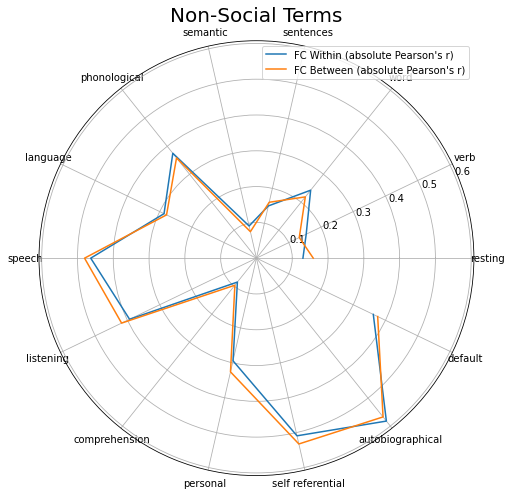

<Figure size 432x288 with 0 Axes>

In [215]:
non_social_categories = ['resting', 'verb', 'word', 'sentences', 'semantic', 'phonological', 'language', 'speech', 'listening', 'comprehension', 'personal', 'self referential', 'autobiographical', 'default']
    
within = [meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['resting'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['verb'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['word'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['sentences'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['semantic'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['phonological'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['language'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['speech'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['listening'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['comprehension'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['personal'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['self referential'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['autobiographical'],
          meta_analysis_fc_G1_within["Pearson's r (abs)"].loc['default']
]


between = [meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['resting'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['verb'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['word'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['sentences'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['semantic'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['phonological'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['language'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['speech'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['listening'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['comprehension'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['personal'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['self referential'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['autobiographical'],
          meta_analysis_fc_G1_between["Pearson's r (abs)"].loc['default']
]

#label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(social))
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(non_social_categories)+1)[0:len(non_social_categories)]

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, social, label="FC Within (absolute Pearson's r)")
plt.plot(label_loc, non_social, label="FC Between (absolute Pearson's r)")
plt.title('Non-Social Terms', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=non_social_categories)
plt.legend()
plt.show()

# export figure
plt.savefig(resdir+'non-social_decoding_FC_within_between.png')

### Other

Worldclout plot display -> doesn't work

In [75]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

ther labels from Neurosynth

In [74]:
labels_margulies = ['face/affective processing', ' verbal semantics', 'cued attention', 'working memory', 
          'autobiographical memory', 'reading', 'inhibition', 'motor', 
          'visual perception', 'numerical cognition', 'reward-based decision making', 'visual attention', 
          'multisensory processing', 'visuospatial','eye movements', 'action',
          'auditory processing', 'pain', 'language', 'declarative memory', 
          'visual semantics', 'emotion', 'cognitive control', 'social cognition']

labels_margulies_minus_missing = [ 'working memory', 
          'autobiographical memory', 'reading', 'inhibition', 'motor', 
          'visual perception', 'visual attention', 
          'visuospatial','eye movements', 'action',
          'pain', 'language', 'emotion', 'cognitive control', 'social cognition']

# chose topic 091 after filtering for "social" (in v5-topics-50) + removed sadness and happiness from topic 091 because missing
labels_topic091 = ['amygdala', 'emotional', 'faces', 'facial', 'emotion', 'expressions', 'neutral', 'fearful', 'happy', 'face', 
           'social', 'emotions', 'response', 'fear', 'angry', 'expression', 'perception', 'recognition', 'sad', 'affective', 
           'threat', 'affect', 'anger', 'magnetic', 'viewing', 'disgust', 'emotionally', 'reactivity', 'resonance', 'cues', 
           'interaction', 'versus', 'suggest', 'threatening', 'fusiform', 'presented', 'gender', 'salient']  

In [63]:
print(f'labels margulies: {len(labels_margulies)}') 
print(f'labels margulies minus missing: {len(labels_margulies_minus_missing)}') 
print(f'labels margulies minus missing: {len(labels_topic091)}') 

labels margulies: 24
labels margulies minus missing: 15
labels margulies minus missing: 38


# Download Neurosynth database using NiMARE 

Tutorial: https://nimare.readthedocs.io/en/0.0.10/auto_examples/01_datasets/download_neurosynth.html

Output is pkl dataset (neurosynth_dataset.pkl.gz) in resdir, so no need to rerun this code if I have it already in my directory

### Importing packages 

In [ ]:
import os
from pprint import pprint

import nimare

import nibabel as nib
import numpy as np
from nilearn import image, masking, plotting

from nimare import annotate, decode
from nimare.dataset import Dataset
from nimare.utils import get_resource_path


from nimare.extract import download_abstracts, fetch_neuroquery, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset

## Creating the dataset

### Download Neurosynth

Neurosynth’s data files are stored at https://github.com/neurosynth/neurosynth-data.

In [ ]:
#### generating topic-based Dataset

# Fetch Neurosynth with *just* the LDA50 features
files = nimare.extract.fetch_neurosynth(
    data_dir=resdir,  # version 0.0.10 switched to data directory
    version="7",
    overwrite=False,
    source="abstract",
    vocab="LDA50",  # Note the difference here
)
neurosynth_db = files[0]
pprint(neurosynth_db)
# Note the "keys" file. That has the top 30 words for each topic.
# It *doesn't* go in the Dataset at all though.

### Convert Neurosynth database to NiMARE dataset file

In [ ]:
# Get the Dataset object
neurosynth_dset = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)

neurosynth_dset.save(os.path.join(resdir, "neurosynth_dataset.pkl.gz"))

### Add article abstracts to dataset

This is only possible because Neurosynth uses PMIDs as study IDs.

In [ ]:
# Add article abstracts to dataset
neurosynth_dset = download_abstracts(neurosynth_dset, "serio@cbs.mpg.de")
neurosynth_dset.save(os.path.join(resdir, "neurosynth_dataset_with_abstracts.pkl.gz"))

## Reducing the dataset

In [71]:
import nimare
import pandas as pd
from nimare.dataset import Dataset

# First, load the dataset as `dset`

# Read in the topic file, rename the ID column, and
# prepend a prefix to the topic names
features = pd.read_table("/data/pt_02542/social_networks/results/Decoding/Datasets/v7/topic50.txt")

topic_names = [c for c in features.columns if c.startswith("topic")]
topics_renamed = {t: "Neurosynth_LDA__" + t for t in topic_names}
topics_renamed["id"] = "study_id"
features = features.rename(columns=topics_renamed)

# Change the data type for the study_id column so it can be merged
features['study_id'] = features['study_id'].astype(str)

dset = Dataset.load(resdir+"/neurosynth_dataset_with_abstracts.pkl.gz")


# Merge the topic dataframe into the annotations dataframe
new_annotations = dset.annotations.merge(
    features, 
    how="inner", 
    left_on="study_id", 
    right_on="study_id"
)
#change dset.annotations
dset.annotations = new_annotations

# The topic file only contains ~10k studies,
# so we must reduce the dataset to match
new_ids = new_annotations["id"].tolist()
# do overall reductions--9950
dset = dset.slice(new_ids)


In [72]:
dset

Dataset(14371 experiments, space='mni152_2mm')

In [73]:
features

,study_id,LDA50_abstract_weight__0_network_state_resting,LDA50_abstract_weight__1_anxiety_trait_personality,LDA50_abstract_weight__2_cerebellar_cerebellum_basal,LDA50_abstract_weight__3_cortex_anterior_cingulate,LDA50_abstract_weight__4_stimulus_time_repetition,LDA50_abstract_weight__5_gyrus_frontal_inferior,LDA50_abstract_weight__6_auditory_speech_temporal,LDA50_abstract_weight__7_reward_feedback_striatum,LDA50_abstract_weight__8_mpfc_social_medial,...,LDA50_abstract_weight__40_face_faces_facial,LDA50_abstract_weight__41_imagery_mental_events,LDA50_abstract_weight__42_visual_cortex_sensory,LDA50_abstract_weight__43_magnetic_mechanisms_human,LDA50_abstract_weight__44_eye_sleep_gaze,LDA50_abstract_weight__45_motion_perception_visual,LDA50_abstract_weight__46_hemisphere_language_stroke,LDA50_abstract_weight__47_attention_attentional_target,LDA50_abstract_weight__48_prefrontal_cortex_pfc,LDA50_abstract_weight__49_depression_mdd_state
0,10022492,0.000723,0.000287,0.021530,0.000853,0.000632,0.055001,0.000442,0.000450,0.000426,...,0.000428,0.000332,0.000736,0.247091,0.000202,0.000287,0.000444,0.000783,0.085157,0.000345
1,10022494,0.000545,0.000216,0.000365,0.024447,0.175033,0.033538,0.040005,0.000340,0.000322,...,0.000323,0.000251,0.079899,0.075234,0.000152,0.031954,0.000335,0.119606,0.000736,0.000260
2,10022496,0.000892,0.000354,0.182336,0.001053,0.000780,0.145740,0.312096,0.000555,0.000526,...,0.000528,0.000410,0.000908,0.071163,0.000249,0.000354,0.000548,0.000965,0.001205,0.000426
3,10051677,0.001760,0.000698,0.001180,0.207028,0.001540,0.210763,0.001076,0.001096,0.001038,...,0.001042,0.000809,0.001792,0.012348,0.000492,0.000699,0.001081,0.001905,0.002377,0.000841
4,10191322,0.000995,0.000395,0.000667,0.015661,0.000871,0.003287,0.000608,0.000620,0.000587,...,0.000589,0.000458,0.001013,0.006982,0.000278,0.000395,0.058554,0.001077,0.030315,0.000475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366,9819274,0.000419,0.000166,0.012473,0.000494,0.000366,0.080635,0.000256,0.000261,0.000247,...,0.000248,0.000193,0.104063,0.204116,0.012310,0.000166,0.000257,0.000453,0.000566,0.000200
14367,9838166,0.000715,0.000284,0.000480,0.000845,0.000626,0.314753,0.000437,0.000446,0.000422,...,0.000423,0.000329,0.000728,0.015432,0.000200,0.000284,0.000439,0.000774,0.000966,0.000342
14368,9862924,0.000424,0.000168,0.000284,0.037530,0.055915,0.038430,0.000259,0.000264,0.000250,...,0.000251,0.000195,0.000432,0.064690,0.000118,0.000168,0.000260,0.000459,0.000573,0.000202
14369,9886448,0.000660,0.000262,0.125402,0.000780,0.000578,0.002181,0.000404,0.000411,0.000390,...,0.000391,0.000304,0.000672,0.081531,0.000185,0.009874,0.202263,0.000715,0.087402,0.000315


## Decoding -> suite from nimare tutorial?

# YUN SHUANG SCRIPT (same as tutorial Neurosynth via NiMARE
** ERROR -> step 3 is problematic but probably restart

In [ ]:
# step1 create dataset

import os
from pprint import pprint

import nimare

import nibabel as nib
import numpy as np
from nilearn import image, masking, plotting

from nimare import annotate, decode
from nimare.dataset import Dataset
from nimare.utils import get_resource_path


from nimare.extract import download_abstracts, fetch_neuroquery, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset

#### generating topic-based Dataset

out_dir = os.path.abspath("/data/p_02542/Fan_ThalamicProject/neurosynth/CPcTFCE/test/")
os.makedirs(out_dir, exist_ok=True)

# Fetch Neurosynth with *just* the LDA50 features
files = nimare.extract.fetch_neurosynth(
    data_dir=out_dir,  # version 0.0.10 switched to data directory
    version="7",
    overwrite=False,
    source="abstract",
    vocab="LDA50",  # Note the difference here
)
neurosynth_db = files[0]
pprint(neurosynth_db)
# Note the "keys" file. That has the top 30 words for each topic.
# It *doesn't* go in the Dataset at all though.

# Get the Dataset object
neurosynth_dset = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
neurosynth_dset.save('Dataset.pkl')

# Add article abstracts to dataset
neurosynth_dset = download_abstracts(neurosynth_dset, "fan@cbs.mpg.de")
neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset_with_abstracts.pkl.gz"))









In [ ]:
# step2 reduce dataset

import nimare
import pandas as pd
from nimare.dataset import Dataset

# First, load the dataset as `dset`

# Read in the topic file, rename the ID column, and
# prepend a prefix to the topic names
df = pd.read_table("/data/hu_fan/Desktop/test/v3/v3-topics-50.txt")
topic_names = [c for c in df.columns if c.startswith("topic")]
topics_renamed = {t: "Neurosynth_LDA__" + t for t in topic_names}
topics_renamed["id"] = "study_id"
df = df.rename(columns=topics_renamed)

# Change the data type for the study_id column so it can be merged
df['study_id'] = df['study_id'].astype(str)

dset = Dataset.load("/data/hu_fan/Desktop/test/neurosynth_dataset_with_abstracts.pkl.gz")


# Merge the topic dataframe into the annotations dataframe
new_annotations = dset.annotations.merge(
    df, 
    how="inner", 
    left_on="study_id", 
    right_on="study_id"
)
#change dset.annotations
dset.annotations = new_annotations

# The topic file only contains ~10k studies,
# so we must reduce the dataset to match
new_ids = new_annotations["id"].tolist()
# do overall reductions--9950
dset = dset.slice(new_ids)


In [ ]:
# step3_decoding
from neurosynth.base.dataset import Dataset
from neurosynth.analysis import decode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['svg.fonttype'] = 'none'
# rank topics according to volumeNO.
def getOrder(d, thr):
    dh = []
    for i in range(0,len(d)):
        di = d[i]
        dh.append(np.average(np.array(range(0,len(d[i]))) + 1, weights=di))
    heatmapOrder = np.argsort(dh)
    return heatmapOrder

# Import neurosynth database:
pickled_dataset = '/data/pt_02542/social_networks/results/Decoding/Datasets/v3/dataset.pkl'
dataset = Dataset.load(pickled_dataset)


# Analysis with 24 terms:
features = pd.read_csv('/data/pt_02542/social_networks/results/Decoding/Datasets/v3/topic50.txt', sep='\t', index_col=0)

#34 topics
topics_to_keep=[0,1,6,7,8,9,11,13,14,15,16,17,19,20,23,25,26,27,28,
29,30,32,33,35,37,38,40,41,42,44,45,46,47,49]

features = features.iloc[:, topics_to_keep]

features=features.rename(columns = lambda x: x.replace('LDA50_abstract_weight__', ''))

dataset.add_features(features, append=False)

# Gradient 1

decoder = decode.Decoder(dataset, method='roi')

# Set threshold:
thr = 0
vmin = 0
vmax = 4

tot = 5
data = decoder.decode([str('/mnt/hgfs/Share/neurosynth/G2/volume_%02d_%02d.nii.gz' % (i * tot, (i * tot) + tot)) for i in range(0,int(100/tot))])
#data = decoder.decode([str('/mnt/hgfs/Share/neurosynth/CPcAllmasks/volume_%02d_%02d.nii.gz' % (i * tot, (i * tot) + tot)) for i in range(0,int(100/tot))])

df = []
df = data.copy()
newnames = []
[newnames.append(('%s-%s' % (str(i * tot), str((i*tot) + tot)))) for i in range(0,len(df.columns))]
df.columns = newnames


dfnew = data
df[df<thr] = 0 
# 9 topics are noise, leaving 25 topics
test=dfnew[~(df==0).all(1)]
test[test<thr] = 0
heatmapOrder = getOrder(np.array(test), thr)

test.columns = newnames

sns.set(context="paper", font="sans-serif", font_scale=2)
f, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(30, 20), sharey=True)
plotData = test.reindex(test.index[heatmapOrder])
cax = sns.heatmap(plotData, linewidths=1, square=True, cmap='Greys', robust=False, 
            ax=ax1, vmin=vmin, vmax=vmax, mask=plotData == 0)

sns.axlabel('Percentile along gradient', 'NeuroSynth topics terms')
cbar = cax.collections[0].colorbar
cbar.set_label('z-stat', rotation=270)
cbar.set_ticks(ticks=[thr,vmax])
cbar.set_ticklabels(ticklabels=[thr,vmax])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.5)

plt.draw()
plt.show()
f.savefig('/mnt/hgfs/Share/neurosynth/newest/33_32cognitive_G1ROI_thr0.svg', format='svg')



# SJH parcellation - example of how to read annot files
(only indicative, I am not using this in my analyses)

In [55]:
lh_sjh_fsa5 = read_annot('/data/pt_02542/social_networks/data/sjh/lh_sjh_fsa5.annot')
rh_sjh_fsa5 = read_annot('/data/pt_02542/social_networks/data/sjh/rh_sjh_fsa5.annot')

In [53]:
lh_sjh_fsa5

(array([ 20, 404,  84, ..., 422, 430, 430], dtype=int32),
 array([[       0,        0,      255,        0, 16711680],
        [     255,        0,        0,        0,      255],
        [       0,      255,        0,        0,    65280],
        ...,
        [      97,      237,       26,        0,  1764705],
        [     193,      202,       26,        0,  1755841],
        [     141,       79,      220,        0, 14438285]], dtype=int32),
 [b'sjh_0',
  b'sjh_1',
  b'sjh_2',
  b'sjh_3',
  b'sjh_4',
  b'sjh_5',
  b'sjh_6',
  b'sjh_7',
  b'sjh_8',
  b'sjh_9',
  b'sjh_10',
  b'sjh_11',
  b'sjh_12',
  b'sjh_13',
  b'sjh_14',
  b'sjh_15',
  b'sjh_16',
  b'sjh_17',
  b'sjh_18',
  b'sjh_19',
  b'sjh_20',
  b'sjh_21',
  b'sjh_22',
  b'sjh_23',
  b'sjh_24',
  b'sjh_25',
  b'sjh_26',
  b'sjh_27',
  b'sjh_28',
  b'sjh_29',
  b'sjh_30',
  b'sjh_31',
  b'sjh_32',
  b'sjh_33',
  b'sjh_34',
  b'sjh_35',
  b'sjh_36',
  b'sjh_37',
  b'sjh_38',
  b'sjh_39',
  b'sjh_40',
  b'sjh_41',
  b'sjh_42',
  b's

In [71]:
# labels: annotation id at each fsaverage vertex (N=10242). If a vertex does not belong to any label and orig_ids=False, its id will be set to -1
lh_sjh_fsa5[0]

array([ 20, 404,  84, ..., 422, 430, 430], dtype=int32)

In [72]:
len(lh_sjh_fsa5[0])

10242

In [81]:
max(lh_sjh_fsa5[0])

504

In [98]:
max(rh_sjh_fsa5[0])

507

In [73]:
# we don't need this
# ctab: color table array (len 505)
lh_sjh_fsa5[1]

array([[       0,        0,      255,        0, 16711680],
       [     255,        0,        0,        0,      255],
       [       0,      255,        0,        0,    65280],
       ...,
       [      97,      237,       26,        0,  1764705],
       [     193,      202,       26,        0,  1755841],
       [     141,       79,      220,        0, 14438285]], dtype=int32)

In [59]:
len(lh_sjh_fsa5[1])

505

In [75]:
# label names
lh_sjh_fsa5[2]

[b'sjh_0',
 b'sjh_1',
 b'sjh_2',
 b'sjh_3',
 b'sjh_4',
 b'sjh_5',
 b'sjh_6',
 b'sjh_7',
 b'sjh_8',
 b'sjh_9',
 b'sjh_10',
 b'sjh_11',
 b'sjh_12',
 b'sjh_13',
 b'sjh_14',
 b'sjh_15',
 b'sjh_16',
 b'sjh_17',
 b'sjh_18',
 b'sjh_19',
 b'sjh_20',
 b'sjh_21',
 b'sjh_22',
 b'sjh_23',
 b'sjh_24',
 b'sjh_25',
 b'sjh_26',
 b'sjh_27',
 b'sjh_28',
 b'sjh_29',
 b'sjh_30',
 b'sjh_31',
 b'sjh_32',
 b'sjh_33',
 b'sjh_34',
 b'sjh_35',
 b'sjh_36',
 b'sjh_37',
 b'sjh_38',
 b'sjh_39',
 b'sjh_40',
 b'sjh_41',
 b'sjh_42',
 b'sjh_43',
 b'sjh_44',
 b'sjh_45',
 b'sjh_46',
 b'sjh_47',
 b'sjh_48',
 b'sjh_49',
 b'sjh_50',
 b'sjh_51',
 b'sjh_52',
 b'sjh_53',
 b'sjh_54',
 b'sjh_55',
 b'sjh_56',
 b'sjh_57',
 b'sjh_58',
 b'sjh_59',
 b'sjh_60',
 b'sjh_61',
 b'sjh_62',
 b'sjh_63',
 b'sjh_64',
 b'sjh_65',
 b'sjh_66',
 b'sjh_67',
 b'sjh_68',
 b'sjh_69',
 b'sjh_70',
 b'sjh_71',
 b'sjh_72',
 b'sjh_73',
 b'sjh_74',
 b'sjh_75',
 b'sjh_76',
 b'sjh_77',
 b'sjh_78',
 b'sjh_79',
 b'sjh_80',
 b'sjh_81',
 b'sjh_82',
 b'sjh_83',
 b

In [60]:
len(lh_sjh_fsa5[2])

505

In [91]:
range(1,10243)

range(1, 10243)

In [97]:
# correspondance between fsaverage vertex and sjh label

lh_sjh_fsaverage = pd.DataFrame({'fsaverage_vertex': range(1,10243), 'sjh_label':lh_sjh_fsa5[0]})
lh_sjh_fsaverage.to_csv('lh_sjh_fsaverage.csv', index = False)

rh_sjh_fsaverage = pd.DataFrame({'fsaverage_vertex': range(1,10243), 'sjh_label':rh_sjh_fsa5[0]})
rh_sjh_fsaverage.to_csv('rh_sjh_fsaverage.csv', index = False)

In [95]:
lh_sjh_fsaverage

,fsaverage_vertex,sjh_label
0,1,20
1,2,404
2,3,84
3,4,445
4,5,386
...,...,...
10237,10238,128
10238,10239,422
10239,10240,422
10240,10241,430


In [104]:
sjh_cluster_1011_mask = pd.read_csv('/data/pt_02542/social_networks/data/sjh_cluster_1011_mask.txt', sep=' ', header=None).astype(int)
sjh_cluster_1011_mask

,0
0,1
1,0
2,0
3,0
4,1
...,...
1006,1
1007,1
1008,1
1009,1


In [110]:
sjh_cluster_1011_mask[0].tolist

<bound method IndexOpsMixin.tolist of 0       1
1       0
2       0
3       0
4       1
       ..
1006    1
1007    1
1008    1
1009    1
1010    1
Name: 0, Length: 1011, dtype: int64>

In [112]:
sjh_cluster_1011_mask[0].tolist().count(1)

462